In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [74]:
# Load the dataset
df = pd.read_csv(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\Traffic Analysis\LSTM-GRU Vehicle Traffic\datasets\lstm_ready_traffic_data.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Optional: convert categorical columns if needed
if df['day_of_week'].dtype == 'object':
    df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

# Select features and target
features = [
    'hour', 'day_of_week', 'month', 'year', 'road_name_encoded',
    'location_encoded', 'suburb_encoded', 'average_speed',
    'maximum_speed', 'Speeding_Incident', 'Speeding_Incident_Avg_Speed'
]
target = 'Total_Traffic_Volume'  # or 'scaled_traffic_volume' if already scaled

# Scale target
scaler = MinMaxScaler()
df['scaled_traffic_volume'] = scaler.fit_transform(df[[target]])

X = df[features].values.astype('float32')
y = df['scaled_traffic_volume'].values.astype('float32')


In [76]:
def create_sequences(X, y, time_steps=48):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


In [108]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [110]:
# 1-Layer GRU Model
gru_single = Sequential()
gru_single.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_single.add(Dropout(0.2))
gru_single.add(Dense(1))

gru_single.compile(optimizer='adam', loss='mse')
history_single = gru_single.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop], verbose=1)


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - loss: 1.5479 - val_loss: 0.0078
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.1316 - val_loss: 0.0079
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0404 - val_loss: 0.0078
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0111 - val_loss: 0.0079
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 9/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.0071 - val_loss: 0.0078
Epoch 10/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 11/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 12/50
789/789 ━━━━━━━━━━

In [111]:
y_pred_gru1 = gru_single.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Single Layer GRU Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
✅ Single Layer GRU Model Evaluation:
RMSE: 0.0883
MAE : 0.0531
R²  : -0.0042


C:\Users\USER\AppData\Local\Temp\ipykernel_1784\244252389.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


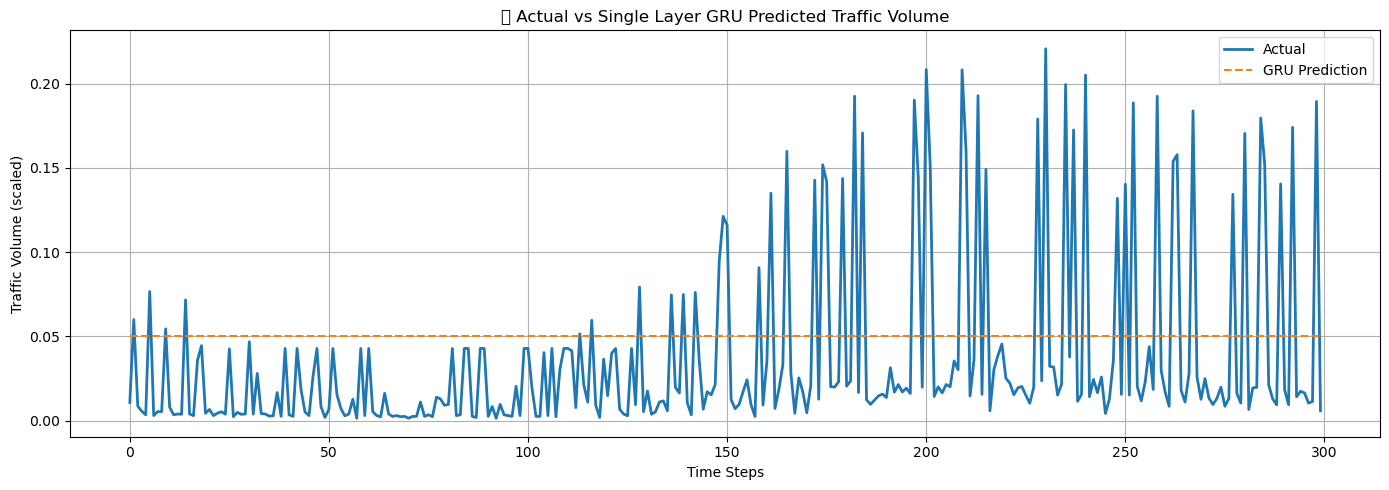

In [112]:
plt.figure(figsize=(14, 5))
plt.plot(y_test[:300], label="Actual", linewidth=2)
plt.plot(y_single[:300], label="GRU Prediction", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume (scaled)")
plt.title("📈 Actual vs Single Layer GRU Predicted Traffic Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
# 2-Layer GRU Model
gru_double = Sequential()
gru_double.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_double.add(Dropout(0.2))
gru_double.add(GRU(32))
gru_double.add(Dropout(0.2))
gru_double.add(Dense(1))

gru_double.compile(optimizer='adam', loss='mse')
history_double = gru_double.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop], verbose=1)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - loss: 0.0392 - val_loss: 0.0083
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - loss: 0.0075 - val_loss: 0.0090
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - loss: 0.0067 - val_loss: 0.0078
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - loss: 0.0070 - val_loss: 0.0079
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 80s 69ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - loss: 0.0065 - val_loss: 0.0079
Epoch 9/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 10/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - loss: 0.0069 - val_loss: 0.0078


In [114]:
# Predict on test set
y_pred_gru2 = gru_double.predict(X_test)

# Calculate metrics
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_gru2))
mae_2 = mean_absolute_error(y_test, y_pred_gru2)
r2_2 = r2_score(y_test, y_pred_gru2)

print("📊 GRU (2-layer) Evaluation Metrics:")
print(f"RMSE: {rmse_2:.4f}")
print(f"MAE : {mae_2:.4f}")
print(f"R²  : {r2_2:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step
📊 GRU (2-layer) Evaluation Metrics:
RMSE: 0.0913
MAE : 0.0483
R²  : -0.0719


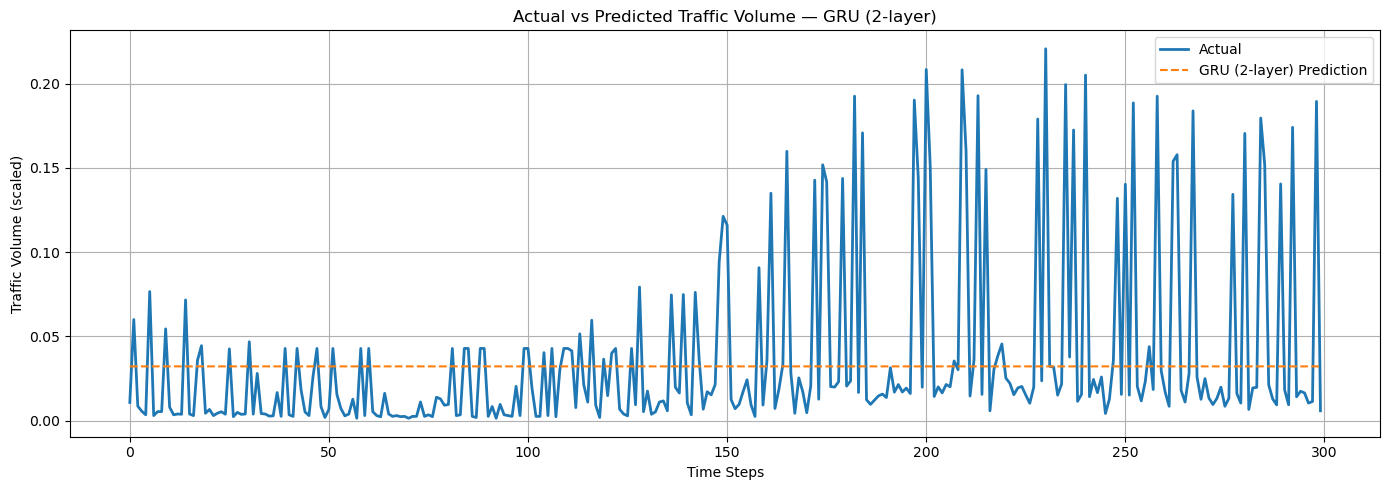

In [115]:
plt.figure(figsize=(14, 5))
plt.plot(y_test[:300], label="Actual", linewidth=2)
plt.plot(y_pred_gru2[:300], label="GRU (2-layer) Prediction", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume (scaled)")
plt.title("Actual vs Predicted Traffic Volume — GRU (2-layer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [116]:
# 3-Layer GRU Model
gru_tri = Sequential()
gru_tri.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_tri.add(Dropout(0.2))
gru_tri.add(GRU(32, return_sequences=True))
gru_tri.add(Dropout(0.2))
gru_tri.add(GRU(16))
gru_tri.add(Dropout(0.2))
gru_tri.add(Dense(1))

gru_tri.compile(optimizer='adam', loss='mse')
history_tri = gru_tri.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop], verbose=1)


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 93s 97ms/step - loss: 0.0193 - val_loss: 0.0081
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - loss: 0.0073 - val_loss: 0.0079
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - loss: 0.0068 - val_loss: 0.0080
Epoch 9/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 10/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - loss: 0.0068 - val_loss: 0.0078


In [117]:
# Predict on test set
y_pred_gru3 = gru_tri.predict(X_test)

# Calculate metrics
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred_gru3))
mae_3 = mean_absolute_error(y_test, y_pred_gru3)
r2_3 = r2_score(y_test, y_pred_gru3)

print("📊 GRU (3-layer) Evaluation Metrics:")
print(f"RMSE: {rmse_3:.4f}")
print(f"MAE : {mae_3:.4f}")
print(f"R²  : {r2_3:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
📊 GRU (3-layer) Evaluation Metrics:
RMSE: 0.0898
MAE : 0.0495
R²  : -0.0368


C:\Users\USER\AppData\Local\Temp\ipykernel_1784\4281241344.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


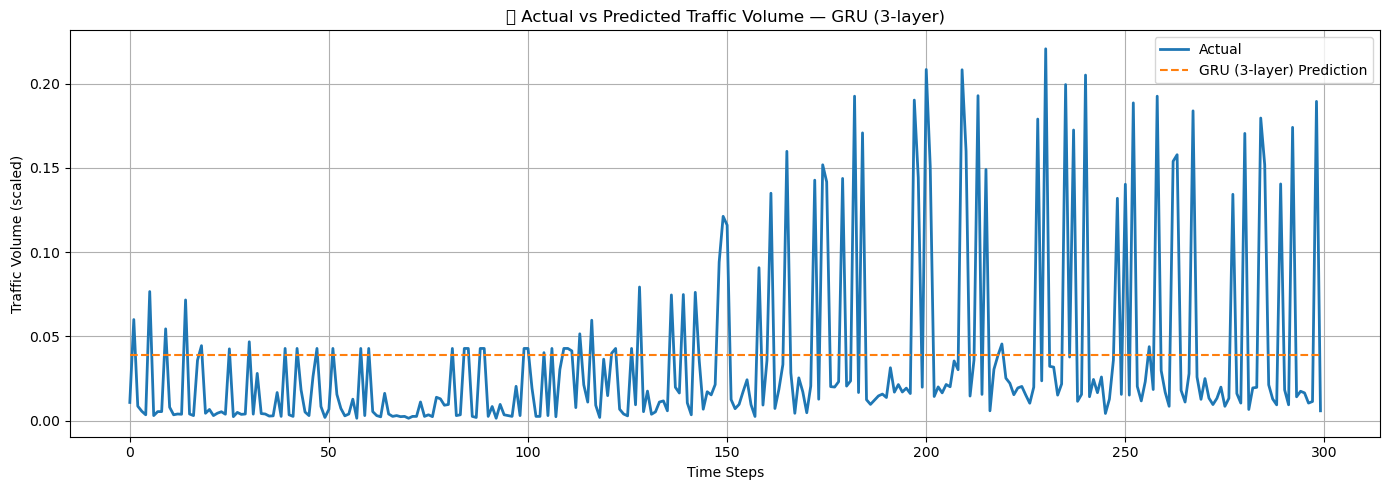

In [118]:
plt.figure(figsize=(14, 5))
plt.plot(y_test[:300], label="Actual", linewidth=2)
plt.plot(y_pred_gru3[:300], label="GRU (3-layer) Prediction", linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume (scaled)")
plt.title("📈 Actual vs Predicted Traffic Volume — GRU (3-layer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

# 4-Layer GRU Model
gru_quad = Sequential()
gru_quad.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_quad.add(Dropout(0.2))
gru_quad.add(GRU(48, return_sequences=True))
gru_quad.add(Dropout(0.2))
gru_quad.add(GRU(32, return_sequences=True))
gru_quad.add(Dropout(0.2))
gru_quad.add(GRU(16))
gru_quad.add(Dropout(0.2))
gru_quad.add(Dense(1))

gru_quad.compile(optimizer='adam', loss='mse')

# Fit the model
history_quad = gru_quad.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[early_stop], verbose=1)
y_pred_gru4 = gru_quad.predict(X_test)




Epoch 1/50


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


789/789 ━━━━━━━━━━━━━━━━━━━━ 92s 104ms/step - loss: 0.0207 - val_loss: 0.0078
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 105ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 139s 100ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 9/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 10/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - loss: 0.0070 - val_loss: 0.0079
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


In [120]:
# Evaluation metrics
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred_gru4))
mae_4 = mean_absolute_error(y_test, y_pred_gru4)
r2_4 = r2_score(y_test, y_pred_gru4)
print("📊 GRU (4-layer) Evaluation Metrics:")
print(f"RMSE: {rmse_4:.4f}")
print(f"MAE : {mae_4:.4f}")
print(f"R²  : {r2_4:.4f}")



📊 GRU (4-layer) Evaluation Metrics:
RMSE: 0.0885
MAE : 0.0525
R²  : -0.0065


In [121]:
# Store all GRU models' metrics
comparison = pd.DataFrame({
    "Model": ["GRU-1Layer", "GRU-2Layer", "GRU-3Layer", "GRU-4Layer"],
    "RMSE": [rmse, rmse_2, rmse_3, rmse_4],
    "MAE": [mae, mae_2, mae_3, mae_4],
    "R2": [r2, r2_2, r2_3, r2_4]
})

comparison

,Model,RMSE,MAE,R2
0,GRU-1Layer,0.088350,0.053061,-0.004162
1,GRU-2Layer,0.091279,0.048289,-0.071861
2,GRU-3Layer,0.089774,0.049502,-0.036810
3,GRU-4Layer,0.088451,0.052524,-0.006461


C:\Users\USER\AppData\Local\Temp\ipykernel_1784\3301420961.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


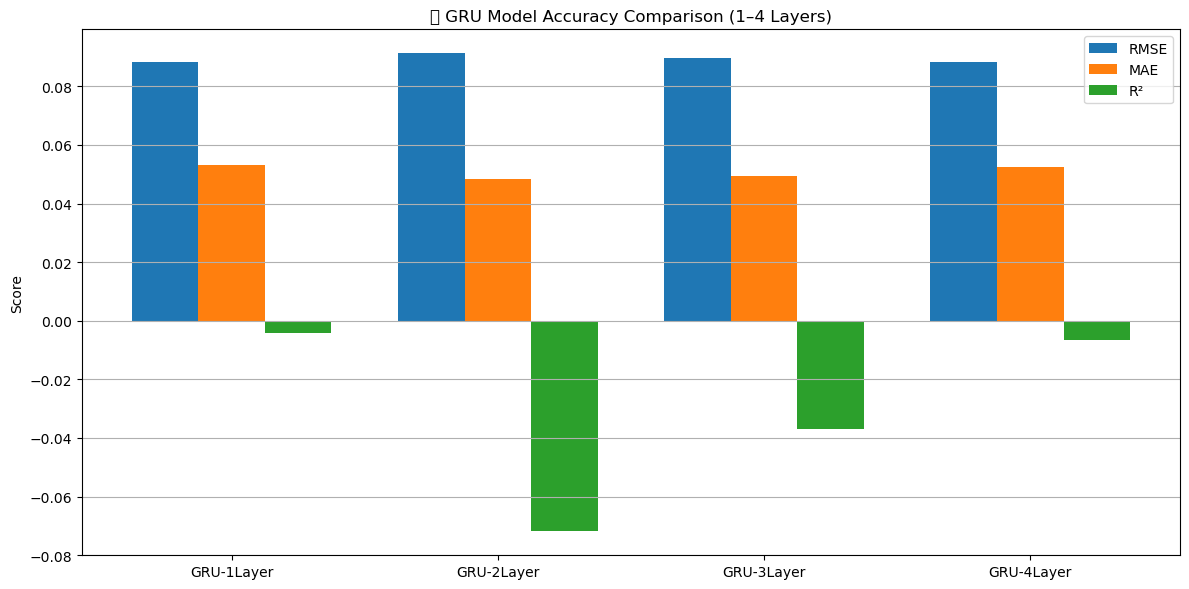

In [122]:
import matplotlib.pyplot as plt

# Build DataFrame
comparison = pd.DataFrame({
    "Model": ["GRU-1Layer", "GRU-2Layer", "GRU-3Layer", "GRU-4Layer"],
    "RMSE": [rmse, rmse_2, rmse_3, rmse_4],
    "MAE": [mae, mae_2, mae_3, mae_4],
    "R2":  [r2, r2_2, r2_3, r2_4]
})

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
x = range(len(comparison))

plt.bar([i - bar_width for i in x], comparison["RMSE"], width=bar_width, label="RMSE")
plt.bar(x, comparison["MAE"], width=bar_width, label="MAE")
plt.bar([i + bar_width for i in x], comparison["R2"], width=bar_width, label="R²")

plt.xticks(ticks=x, labels=comparison["Model"])
plt.ylabel("Score")
plt.title("📊 GRU Model Accuracy Comparison (1–4 Layers)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Python Version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
TensorFlow Version: 2.17.0
GPU is not available


In [146]:
import tensorflow as tf
import platform
import sys

print("Python Version:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow Version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    for gpu in gpus:
        print("GPU Device:", gpu.name)
else:
    print("GPU is not available")


Python Version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
TensorFlow Version: 2.17.0
GPU is not available
